# Introduction
---
This notebook shows how to load the Svalbard Sentinel-1 avalanche detection dataset. The spatial and temporal distribution will be plotted. 

Each detection is based on changes in the backscatter between two successive satellite images taken at approximately the same viewing angle (at the same relative orbit). The time separation between two successive satelitte aqusitions is typically 6 days. The time uncertainty of a single detection is thus typically 6 days. If multiple detections are made at the same location and overlapping in time, they are assume to be associated to the same avalanche and aggregated, and the time uncertainty of the aggregated detection is reduced. The time uncertainty of the detections in the dataset can thus vary greatly. 

In order to display the time evolution of the avalanche activity, and incorporate the time uncertainty of each detection, a so called avalanche detection density (ADD) is introduced. This notebook shows how to compute this. 


# Import libraries
___
Import some libraries:

In [9]:

import os
import urllib
from io import BytesIO

import geopandas as gpd
import numpy as np
from sklearn.neighbors import KernelDensity

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import contextily as cx

import sys
sys.path.append('/Users/jakob/code/cvl-3d-viz/')
from cvl.viz import viz
from dateutil import parser
import datetime
import json
from IPython.display import IFrame

# Read data
___
Read the geojson file from url to a geopandas dataframe. Since the file is some hundreds of megabytes, reading it may take some minutes. 

In [2]:
url = 'https://thredds.met.no/thredds/fileServer/arcticdata/infranor/norceavalanche/SAR-avalanche-detections-20170204-20210530.geojson'
with urllib.request.urlopen(url) as r: 
    aval = gpd.read_file(BytesIO(r.read()), driver='GeoJSON')
aval.t_0 = gpd.pd.DatetimeIndex(aval.t_0)
aval.t_1 = gpd.pd.DatetimeIndex(aval.t_1)

# Plot spatial distribution
___

The dataset consists of 31899 individual avalanche detections, covering the time period from February 2017 to May 2021. A map showing the spatial distribution of detections is displayed below. Most detections are found on the western parts of Svalbard. 

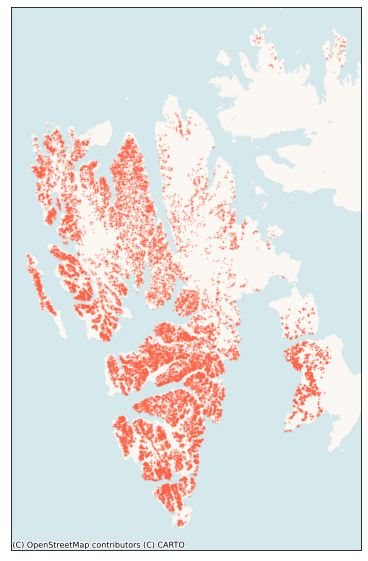

In [3]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
aval.to_crs(epsg=3857).centroid.plot(markersize=1, ax=ax, color='tomato', alpha=.25)
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Alternatively, this dataset can also be viewed in the CVL 3D-visualisation tool. Lets embed it here: 

In [11]:
IFrame("https://nlive.norceresearch.no/cvl/", width=1400, height=1200)

You can also start a local server and post your own objects to the visualisation tool. See [here](https://github.com/CryosphereVirtualLab/cvl-3d-viz/blob/master/README.md) for information on how to start a local server. When this is running, we can post avalanche detections to it and view them in the CLV-map above. Let's post the avalanches detected in April 2021: 

In [10]:
# Define subset: 
subset = aval[(aval.t_0 > np.datetime64('2021-04-01')) & (aval.t_0 < np.datetime64('2021-05-01'))]

# Post to server: 
visualizer = viz()
for i in range(len(subset)): 
    metadata = { 
        "info": "Avalanche subset", 
        "stroke": "rgba(0, 0, 255, 1)", 
        "fill": "rgba(0, 0, 128, 0.5)", 
        "strokeWidth": "1.0", 
        "path" : "Avalanche subset", 
        "name" : "Timeseries", 
        "geojson" :  json.loads(subset[['geometry']].iloc[i:i+1].to_crs('epsg:4326').to_json())['features'][0], 
        "time_start" : subset.iloc[i].t_0.timestamp(), 
        "time_stop" : subset.iloc[i].t_1.timestamp(),  
    }
    visualizer.publish_geojson(f"item-{i:04d}", metadata)

# Avalanche detection density (ADD)
___
To account for the time uncertainty of the avalanche detections, we introduce the so called ADD. This is a kernel density estimate, where each detection is represented by a top-hat kernel with a width corresponding to the time uncertainty of the detection. The area of each kernel is further weighed by the size of the avalanche. We follow the weighting standard used by for example [2], where the weights are 0.01, 0.1, 1 and 10 for the avalanche size categories 1–4 respectively. An illustration of the ADD parameter is show below: 

![Avalanche detection density (ADD)](add_sketch.png "Avalanche detection density (ADD)")

First extract some useful parameters: 

In [12]:
# Convert times to numpy datetime: 
aval['t_0'] = aval['t_0'].apply(lambda x: np.datetime64(x))
aval['t_1'] = aval['t_1'].apply(lambda x: np.datetime64(x))

# Compute center times: 
aval['t_c'] = aval['t_0'] + (aval['t_1'] - aval['t_0'])/2

# Compute days from reference time (useful for interpolation later): 
t_ref = np.datetime64(np.min(aval['t_c']))
aval['t_ref'] = t_ref
aval['day_count'] = (aval['t_c'] - np.min(aval['t_ref']))/np.timedelta64(1,'D')

# Compute detection duration: 
aval['duration'] = (aval['t_1'] - aval['t_0'])/np.timedelta64(1,'D')

# Compute area and size weights: 
aval['area'] = aval.to_crs('epsg:32633').area
aval['size_class'] = np.floor(np.log10(aval['area']))
aval['size_class'] = aval['size_class'].apply(lambda x: 4 if x > 4 else x)
aval['size_weight'] = np.power(10, aval['size_class']-3)

Define the ADD parameter: 

In [13]:
class AvalancheDetectionDensity(): 
    
    def __init__(self, data, t_ref): 
        data = data.copy()
        self.t_ref = t_ref
        kde_list = []
        for key, g in data.groupby(['duration', 'size_weight']): 
            b, w = key
            x = np.array(g['day_count']).reshape(-1, 1)
            kde_list.append((KernelDensity(kernel='tophat', bandwidth=b).fit(x), len(x), w))
        self.kde_list = kde_list
        
    def compute(self, t): 
        x = (t-self.t_ref)/np.timedelta64(1, 'D')
        return sum([np.exp(f.score_samples(x.reshape(-1, 1)))*n*w for f, n, w in self.kde_list])

# Compute ADD: 
add = AvalancheDetectionDensity(aval, t_ref)

# Plot temporal distribution: 
___
To quantify the temporal distribution of avalanches, the Avalanche Detection Density (ADD) parameter is plotted below. It is evident from the figure that avalanche activity is organised in cycles. All seasons show one or two clear cycles in spring. The 2018-2019 and 2020-2021 seasons also have cycles in the autumn.  

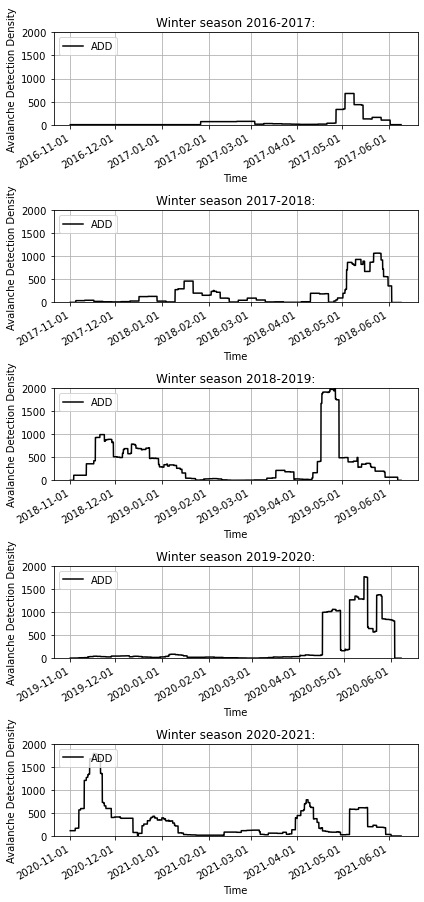

In [14]:
years = range(2016, 2021)
fig, axs = plt.subplots(len(years), 1, figsize=(6,2.5*len(years)))
for yr, ax in zip(years, axs): 
    x = np.arange(0, 220, .05)
    t = np.datetime64(f'{yr:04d}-11-01') + x*24*60*60*np.timedelta64(1, 's')
    ax.plot(t, add.compute(t), label=f'ADD', color='k')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_ylabel('Avalanche Detection Density')
    ax.set_xlabel('Time')
    ax.set_ylim([0, 2000])
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_title(f'Winter season {yr:04d}-{yr+1:04d}:')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()